In [1]:
#imports
import sys
import subprocess 
import importlib

import time

import numpy as np

import scipy.constants as con
import scipy.optimize as opt
import scipy.linalg as la
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack
from scipy.interpolate import interp1d 

from numba import njit


import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()

#Nice plots
import matplotlib.pyplot as plt
import matplotlib.ticker as plticks
width = 5.1
fontsize = 10
plt.rcParams.update({
    'text.usetex'        : True,
    'font.family'        : 'sans-serif',
    'font.size'          : fontsize,
    'text.latex.preamble': r'\usepackage{libertine}'
})
#plt.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
import re
from pylatexenc.latexencode import UnicodeToLatexEncoder, \
 UnicodeToLatexConversionRule, RULE_REGEX
u2latex = UnicodeToLatexEncoder(
    conversion_rules=[
        UnicodeToLatexConversionRule(rule_type=RULE_REGEX, rule=[
            (re.compile(r'𝜈'), r'\\ensuremath{\\nu}'),
            (re.compile(r'𝛾'), r'\\ensuremath{\\gamma}'),
            (re.compile(r'⁻'), r'\\ensuremath{^-}'),
            (re.compile(r'⁺'), r'\\ensuremath{^+}'),
        ]),
        'defaults'
    ]
)

In [1]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 

n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931.494102          #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
#infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
molcm3=216117376    #conversion factor for mol/cm^3 (cm^3*MeV^3)/(hbar^3*c^3*Avagadro number)
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
e_mass=0.51099895   #electron mass in MeV


def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

T_ini=5                     #initial temperature in MeV

t_ini=3/(2*np.sqrt(43/5*G*np.pi**3))/T_ini**2 #initial time in hbar/MeV


z_ini=e_mass/T_ini

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701178*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta_ini*n_gamma_ini  #initial h


n_b_ini=eta_ini*n_gamma_ini    #initial baryon number density
rho_b_ini=M_u*n_b_ini           #initial baryon density

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4

def n_b(a):
    return #n_b_ini/a**3

def rho_b(a):
    return rho_b_ini/a**3


### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(a)+rho_b(a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))


#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)



t_range=[t_ini,2e5*timeunit]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]

# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='Radau',atol=1e-80,rtol=1e-8,t_eval=np.geomspace(*t_range,100000))#,t_eval=t_space)

fig, axes = plt.subplots(1, 1, figsize=(width, 3))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.125, right=0.985, bottom=0.145, top=0.95)

# Plot the Temperature


# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(3/(2*np.sqrt(43/5*G*np.pi**3))/t_space)
plt.plot(t_space/timeunit, T_approx,'k', label='Approximate temperature')


#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(sol.t/timeunit, sol.y[0],'b--', label='Photon temperature')
plt.plot(t_space/timeunit, T_ini/sol.y[1],'r:', label='Neutrino temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('Time (s)')
plt.ylabel('Temperature (MeV)')

plt.xscale('log')
plt.yscale('log')

plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#plt.figure

Tsqr=sol.y[0]**-2
asqrt=sol.y[1]**2

n_bparams=2

solt=sol.t

@njit
def T_cache(t):   #solve h and T, y[0] = T, y[1] = a
    return 1/np.sqrt(np.interp(t,solt,Tsqr))
    #return -np.interp(t,sol.t,-sol.y[0])
    #return -interp1d(sol.t,-sol.y[0], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

@njit
def a_cache(t):
    return np.sqrt(np.interp(t,solt,asqrt))
    #return np.interp(t,sol.t,sol.y[1])
    #return interp1d(sol.t,sol.y[1], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

#fig.savefig('TeX/figures/Temperature.pdf')

NameError: name 'np' is not defined

In [3]:
t_ini/timeunit

0.029531842660077835

In [4]:
(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini)))

2.748115763990545

In [5]:
#import networks

#section for AoT compilation of network
#import H2_AoT_net as bbn_H2
#import He4_AoT_net as bbn_He4

import np_AoT_net as bbn_np
import AoT_net as bbn_Li
import full_AoT_net as bbn_full

networks=[bbn_np,bbn_Li,bbn_full]
#number of nuclei in network, nNucs[-1]=2 to since initial condition sets n and p
nNucs=[net.nnuc if isinstance(net.nnuc, int) else net.nnuc() for net in networks]+[2]
'''

#Jit compilation
import bbn_test_integrate as bbn_Li
#import full_size_net as bbn_full
import Newrate_net as bbn_full
networks=[bbn_Li,bbn_full]
nNucs=[net.nnuc for net in networks]+[2]


#compile rhs and Jacobians
for i in range(len(networks)):
    prev_time=time.time()
    networks[i].rhs(float(1000), np.ones(nNucs[i]),0.00001, float(1e7))
    print(str(i+1)+f'. rhs compiled in {time.time()-prev_time:.2f} seconds')
    prev_time=time.time()
    networks[i].jacobian(float(1000), np.ones(nNucs[i]),0.00001, float(1e7))
    print(str(i+1)+f'. jacobian compiled in {time.time()-prev_time:.2f} seconds')
'''

tLi=3/(2*np.sqrt(43/5*G*np.pi**3))/(20/TMeV2T9 )**2
tfull=3/(2*np.sqrt(43/5*G*np.pi**3))/(2/TMeV2T9 )**2

#tLi=10*timeunit
#times for switching between networks
t_start=[t_ini,tLi,tfull,1e5*timeunit]




In [6]:
tfull/timeunit

24.85563056420933

In [7]:
prev_time=time.time()
T_cache(1.1)

a_cache(1.1)
print(f'Background interpolation compiled in {time.time()-prev_time:.2f} seconds')

Background interpolation compiled in 2.39 seconds


In [8]:
#Setup isotopes based on Alterbbn
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]

fnNucs=nNucs[-2]

A=np.array([1,1,2,3,3,4,6,7,8,7,9,8,10,11,12,11,12,13,14,12,13,14,15,14,15,16])
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]

Z=sorted([0,1,1,1,2,2,3,3,4,3,5,4,5,5,6,5,6,7,6,7,6,7,8,7,8,8])
Alter_Z=[0.,1.,1.,1.,2.,2.,3.,3.,4.,3.,5.,4.,5.,5.,6.,5.,6.,7.,6.,7.,6.,7.,8.,7.,8.,8.]

def Altersort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])])
#print([label for _, label in sorted(zip(A, Y_labels))])

def PNAsort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])])    


Alterspin=[0.5,0.5,1.,0.5,0.5,0.,1.,1.5,1.5,2.,2.,1.5,3.,1.5,1.5,1.,0.,1.,0.5,0.5,0.,1.,0.,0.5,0.5,0.]
spin=PNAsort(Alterspin)

Alter_mass_excess=[8.071388,7.289028,13.135825,14.949915,14.931325,2.424931,14.0864,14.9078,15.7696,20.9464,22.9212,11.34758,12.05086,8.6680,10.6506,13.3690,0.,17.3382,3.125036,5.3455,3.019916,2.863440,8.006521,0.101439,2.8554,-4.737036]
Alter_mass=[Alter_A[i]*M_u+Alter_mass_excess[i] for i in range(fnNucs)]
m_Nucs = np.array(PNAsort(Alter_mass))
m_n,m_p,m_d,m_t,m_He3,m_He4=m_Nucs[:6]


def rho_bY_cgs(y):
    return np.dot(y[n_bparams:6+n_bparams],m_Nucs[:6])*eta_ini*n_gamma_ini/y[1]**3*gcm3



B=[(m_Nucs[1]*Z[i]+m_Nucs[0]*(A[i]-Z[i]))-m_Nucs[i] for i in range(fnNucs)]
g = 1+2*np.array(spin)

print(Alter_Yl)
print(Altersort(Y_labels))

print(Y_labels)
print(PNAsort(Alter_Yl))

['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']


In [9]:
#Functions for determining additional abundances for each network

#Initial conditions from thermal equilibrium
def get_Y_thermal(Y,n,T):
    Y_2 = np.zeros(n)
    Y_2[:len(Y)] = Y
    for i in range(len(Y),n):
        tmp = special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
        Y_2[i] = g[i]*tmp*(T/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Y[1]**Z[i]*Y[0]**(A[i] - Z[i])*np.exp(B[i]/T)/A[i]

    return Y_2

def solve_using_svd(U, s, Vh, b):
    bb = U.T @ b
    y = bb/s
    x = Vh.T @ y
    return x

#Initial conditions from Jacobian
def get_Y_jac(y,i):

    AdYdt_cut=lambda Y : Altersort(networks[i].rhs(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9))
    AdYdt_jac_cut=lambda Y : networks[i].jacobian(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9)[:, Altersort(range(nNucs[i]))][Altersort(range(nNucs[i]))]
    aY_cut=Altersort(get_Y_thermal(y[n_bparams:][:nNucs[i-1]],nNucs[i],y[0]))

    Yj = np.array([YY for YY in aY_cut])
    
    
    for cut in range(nNucs[i-1], len(Yj) - 2, 1):
        for j in range(10):
            fyj = -AdYdt_cut(Yj)
            jac = AdYdt_jac_cut(Yj)
            if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
                print('Yj:', Yj)
                raise ValueError
            if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
                print('Yj:', Yj)
                print('fyj:', fyj)
                raise ValueError
            # Implement cut:
            fyj = fyj[cut:]
            jac = jac[cut:, cut:]
            
            # Solution using SVD
            U, s, Vh = la.svd(jac)    
            x = solve_using_svd(U, s, Vh, fyj)
            for k in range(1):
                #A · δx = A · (x + δx) − b
                residuals = jac @ x - fyj
                dx = solve_using_svd(U, s, Vh, residuals)
                x -= dx
            Yj[cut:] += x
    return list(PNAsort(Yj))

In [10]:
#Solve the system
#initial conditions

solY=np.array([[1/(np.exp(Q/T_ini)+1)],[1/(np.exp(-Q/T_ini)+1)]])
soltime=np.array([t_ini])
derivtime=0
jactime=0
backgroundtime=0
inittime=[]
solvetime=[]


for i in range(len(networks)):

    #[T_ini],[1]
    
    tid=time.time()
    initial_param=get_Y_jac(np.array([T_cache(t_start[i]),a_cache(t_start[i])]+list(solY[:,-1])),i)
    inittime+=[time.time()-tid]

    #Give PyNucAstro jacobian nessecary parameters
    def jacPNA(t,Y):
        global jactime
        tid=time.time()
        jac=networks[i].jacobian(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
        jactime+=time.time()-tid
        return jac
    

    #full derivative
    def dydt(t,Y): 
        global derivtime      
        global backgroundtime
        tid=time.time()
        T_cache(t+t_start[i])
        a_cache(t+t_start[i])
        backgroundtime+=time.time()-tid
        tid=time.time()
        result=list( networks[i].rhs(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit)      
        derivtime+=time.time()-tid

        return result
    
    tid=time.time()
    jacsolY = integrate.solve_ivp(dydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-8,jac=jacPNA)#,first_step=timeunit*1e-3)#,t_eval=t_space)
    solvetime+=[time.time()-tid]

    abun=[abun[-1] for abun in jacsolY.y]
    
    #for leaving long lines
    #solY=np.concatenate((np.concatenate((solY,np.multiply(np.ones((len(solY[0]),nNucs[i]-nNucs[i-1])),initial_param[len(solY):]).T)),jacsolY.y),axis=1)
    solY=np.concatenate((np.concatenate((solY,np.full((nNucs[i]-nNucs[i-1],len(solY[0])), np.nan, order='C'))),jacsolY.y),axis=1)

    soltime=np.concatenate((soltime,jacsolY.t+t_start[i]))


In [11]:
print(backgroundtime)
print(derivtime)
print(jactime)
print(inittime)
print(solvetime)
print(derivtime+jactime)

print(sum(solvetime))

0.13657617568969727
0.9181845188140869
0.06156587600708008
[0.00012612342834472656, 0.01737189292907715, 0.025598764419555664]
[0.08629965782165527, 0.8458361625671387, 2.4073784351348877]
0.979750394821167
3.3395142555236816


In [12]:
#solving with full network



final_abun=[fabun[-1] for fabun in solY]


print([final_abun[0],final_abun[1],2*final_abun[2],3*final_abun[3],3*final_abun[4],4*final_abun[5]])
print('sum: ', sum(np.array(final_abun)*A[:fnNucs]))
#7.886337979878622e-12, 0.7527267953552783, 3.721765446008321e-05, 1.818864964420758e-07, 2.3975426938891067e-05, 0.24721182706460487

[8.276548687340971e-12, 0.7528726749493345, 3.814108895886233e-05, 1.8511110556027686e-07, 2.3298826106467195e-05, 0.24706569753546861]
sum:  1.0000000000017553


In [13]:
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))



Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.471e-01	 2.533e-05	 1.040e-05	 4.710e-10	 7.506e-15	 4.410e-10


In [14]:
solY[9,100]

2.1788313461313823e-67

In [15]:
T_cache(soltime[1200])*TMeV2T9

2.31170773180518

In [16]:
T_cache(soltime[900])

0.2862633026629497

In [17]:
T_cache(soltime[1150])*TMeV2T9

2.4565981644112553

In [18]:
n_b_ini/a_cache(soltime[1150])**3*molcm3

0.000606266450686751

In [19]:
soltime[1150]/timeunit

19.88115954992492

In [20]:
np.array([fabun[1150] for fabun in solY])

array([1.63453669e-01, 8.36546331e-01, 1.69488856e-10, 1.71002441e-12,
       2.37347340e-13, 1.25902235e-11, 2.33477060e-32, 3.52325374e-32,
       1.03621357e-42, 7.62321315e-35,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan])

In [21]:
np.array([fabun[1200] for fabun in solY]*A[:fnNucs])

array([1.62285500e-01, 8.37714499e-01, 5.75409622e-10, 3.60673545e-11,
       4.02759796e-12, 3.20137241e-10, 2.06575955e-30, 2.02191040e-29,
       1.08826963e-39, 2.71167018e-32,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan])

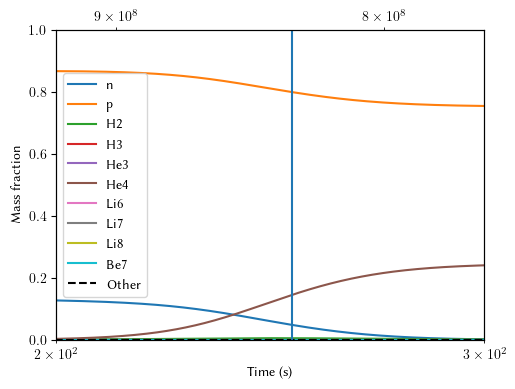

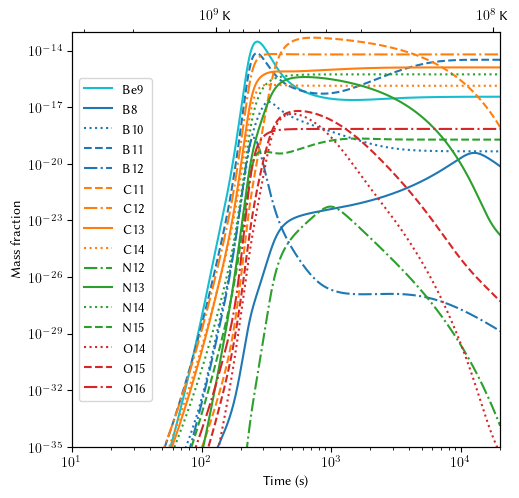

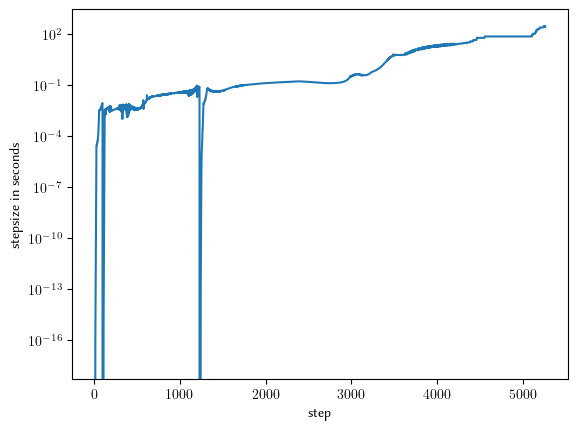

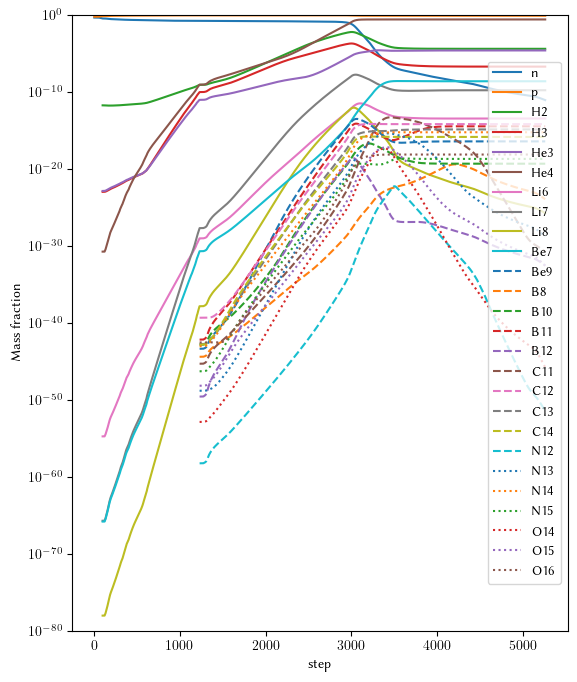

In [100]:
# Plot the results    

#class for adding units to axis
class AddK(plticks.LogFormatterSciNotation):
    def __call__(self, x, pos=None):
        x = plticks.LogFormatterSciNotation.__call__(self, x,pos)
        s = x+' K'
        return s

#plt.figure('abundance',figsize=(6.4, 8))
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.125, top=0.9)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=8
line=['-']*10+['--']*10+[':']*10+['-.']*10+['-']*10+['--']*10+[':']*10+['-.']*10


for i in range(10,fnNucs):
    plt.plot(soltime/timeunit, A[i]*solY[i],'k--')
for i in range(10):
    plt.plot(soltime/timeunit, A[i]*solY[i],line[i], color=colors[i], label=Y_labels[i])
plt.plot(soltime/timeunit, A[19]*solY[19],'k--', label='Other')

plt.axvline(250)
plt.xlabel('Time (s)')
plt.ylabel('Mass fraction')
xlims=(200,300)
plt.ylim(1e-18,1)
plt.xlim(*xlims)
plt.xscale('log')
#plt.yscale('log')

plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9  for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())
#fig.savefig('TeX/figures/abundancelight.pdf')
plt.show()

####

fig, axes = plt.subplots(1, 1, figsize=(width, 5))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.1, top=0.93)

lateline=['-.','-',':','--']

#for i in range(10,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[(Z[i]-A[i])% 4], color=colors[A[i]-8], label=Y_labels[i])

for i in range(10,fnNucs):
    plt.plot(soltime/timeunit, A[i]*solY[i],'-' if i==11 else lateline[A[i]% 4], color=colors[(i-11)//4], label=Y_labels[i])



#plt.plot(soltime/timeunit, A[10]*solY[10],'k:', label='Be9')
#for i in range(11,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[i], color=colors[i% 4], label=Y_labels[i])

  
#plt.axvline(soltime[1200]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('Mass fraction')
plt.ylim(1e-35,1e-13)
xlims=(10,2e4)
plt.xlim(*xlims)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9 for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())

#fig.savefig('TeX/figures/abundanceheavy.pdf')
plt.show()

######

plt.figure('step size')
plt.plot(range(len(soltime)),[(soltime[i]-soltime[i-1])/timeunit for i in range(len(soltime))] )

plt.yscale('log')
plt.xlabel('step')
plt.ylabel('stepsize in seconds')
plt.show()

plt.figure('abundance',figsize=(6.4, 8))

for i in range(fnNucs):
      plt.plot(range(len(soltime)), A[i]*solY[i],line[i], color=colors[i], label=Y_labels[i])

plt.xlabel('step')
plt.ylabel('Mass fraction')
plt.ylim(1e-80,1)
#plt.xlim(0,20)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='right')
plt.show()

(300.0, 180.0)

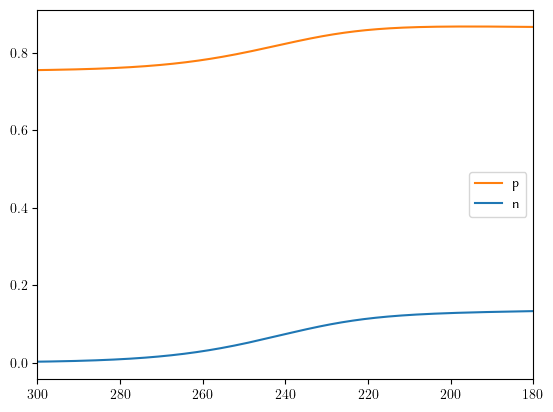

In [23]:
plt.plot(soltime/timeunit, A[1]*solY[1],line[1], color=colors[1], label=Y_labels[1])
plt.plot(soltime/timeunit, A[0]*solY[0],line[0], color=colors[0], label=Y_labels[0])
#plt.xscale('log')
plt.legend(loc='right')
plt.xlim(300,180)

In [24]:
print(' ')
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')
abun=final_abun
print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))
#value:	 2.470e-01	 2.532e-05	 1.040e-05	 4.711e-10	 7.503e-15	 4.411e-10
#40MeV
#2.471e-01	 2.534e-05	 1.040e-05	 4.709e-10	 7.511e-15	 4.408e-10

#ny rate
#2.472e-01	 2.472e-05	 1.070e-05	 4.946e-10	 7.331e-15	 4.647e-10

#gammel rate
#2.472e-01	 2.537e-05	 1.040e-05	 4.706e-10	 7.522e-15	 4.404e-10

 
Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.471e-01	 2.533e-05	 1.040e-05	 4.710e-10	 7.506e-15	 4.410e-10


In [25]:
print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))


value:	 2.471e-01	 2.533e-05	 1.040e-05	 4.710e-10	 7.506e-15	 4.410e-10


In [26]:
n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) 

In [27]:
(abun-np.array([8.276335484211192e-12,
 0.7529021320046096,
 1.9065745790827655e-05,
 6.168695549954791e-08,
 7.7657888757561e-06,
 0.061759062896670214,
 5.648697590489025e-15,
 2.2648491645742273e-11,
 2.202606350493477e-27,
 3.3207831824563064e-10,
 4.0124893719663395e-18,
 1.4000624746122144e-25,
 4.575795402144344e-21,
 2.98222372302936e-16,
 2.342042643640744e-34,
 1.5142481481178972e-32,
 5.2693110542489445e-16,
 9.938614533513088e-17,
 9.81170469767044e-18,
 3.0213555424266857e-53,
 1.1496284981862578e-30,
 3.9537869737609504e-17,
 1.2812653778770662e-20,
 1.1611372885488144e-47,
 1.6894763876387458e-34,
 4.426001601678373e-20]))/abun

array([ 2.57599076e-05, -3.91262112e-05,  2.51628296e-04,  2.71399501e-04,
        6.26417482e-05,  1.19182667e-04,  4.08224350e-04,  3.38672304e-04,
        1.37010613e-04, -2.93563071e-04,  6.58108456e-04, -1.23479770e-03,
        7.43594373e-04,  1.00959698e-04, -2.82637629e-04, -2.08918599e-04,
        3.48519090e-04,  2.15758676e-04,  2.29230884e-04, -1.39311581e-03,
       -8.45829698e-04,  4.84852299e-05,  2.62524153e-04, -2.14816397e-03,
       -1.24248639e-03,  1.59278429e-04])

In [28]:
rho_gamma(T_ini)/(2.701*T_ini) 

30.45046402903047

In [29]:
rho_gamma(T_cache(timeunit*1e5))/(2.701*T_cache(timeunit*1e5)) 

1.162585249029659e-08

In [30]:
1.20206*2/np.pi**2*T_cache(timeunit*1e5)**3 

1.162511618731163e-08

In [31]:
a_cache(timeunit*1e5)

1930.7038958665123

In [32]:
#rho_b_ini=M_u*eta_ini*n_gamma_ini    #initial baryon density


rho_b_ini/(a_cache(timeunit*1e5)**3*M_u*rho_gamma(T_cache(timeunit*1e5))/(2.701178*T_cache(timeunit*1e5)) )

6.100802227047518e-10

In [33]:
6.1/((1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini)))/(1+(rho_e(T_ini))/(rho_gamma(T_ini))))

6.1014585568293365

In [34]:
11/4/(1+(rho_e(1))/(rho_gamma(1)))

1.0126629289413693

In [35]:
11/4/(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini)))

1.0006856465197518

In [36]:
rho_b_ini/(a_cache(timeunit*1e5)**3*M_u*rho_gamma(T_cache(timeunit*1e5)))

6.226635458909456e-08

In [37]:
(2.701*T_cache(timeunit*1e5))

0.009797265700989885

In [38]:
(rho_b(1)/M_u)/(rho_gamma(T_ini)/(2.701*T_ini))

1.6762401492639365e-09

In [39]:
(rho_b(a_cache(timeunit*1e5))/M_u)/(rho_gamma(T_cache(timeunit*1e5))/(2.701*T_cache(timeunit*1e5)))

6.100400201414103e-10

In [40]:
drho_e(T_cache(timeunit*1))

2.927975315522944

In [41]:
drho_gamma(T_cache(timeunit*1))

1.6951156893981565

In [42]:
T_cache(timeunit*10)/M_u*1.5

0.0004623999654440634

In [43]:
m_n/m_He4*4


1.0080089610224228

In [44]:
m_p/m_n

0.9991673172244758

In [45]:
rho_e(T_ini/2)/P_e(T_ini/2)

3.0177220357856056

In [46]:
rho_gamma(T_ini)/P_gamma(T_ini)

3.0

In [47]:
len(solY[:,1])

26

In [48]:
m_Nucs

array([  939.56549 ,   938.78313 ,  1876.124029,  2809.432221,
        2809.413631,  3728.401339,  5603.051012,  6535.366514,
        7472.899216,  6536.228314,  8394.794498,  7474.874016,
        9326.99188 , 10255.103122, 11191.298224, 10257.085722,
       11177.929224, 12112.548362, 13043.937344, 11195.267424,
       12114.768826, 13043.780868, 13972.512969, 13048.923949,
       13975.26693 , 14899.168596])

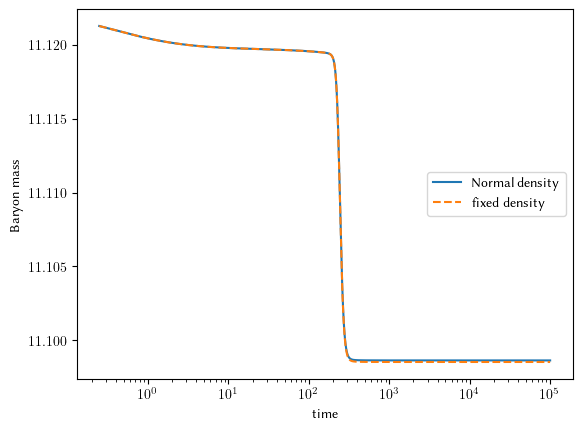

In [49]:
invm=A**2/m_Nucs


def altrho_bY_cgs(y):
    return eta_ini*n_gamma_ini/y[1]**3*gcm3/np.dot(y[n_bparams:6+n_bparams],invm[:6])
    


plt.figure()
plt.plot(soltime/timeunit,[a_cache(soltime[i])**3*rho_bY_cgs(np.array([T_cache(soltime[i]),a_cache(soltime[i])]+list(solY[:,i]))) for i in range(len(soltime))],label='Normal density')
plt.plot(soltime/timeunit,[a_cache(soltime[i])**3*altrho_bY_cgs(np.array([T_cache(soltime[i]),a_cache(soltime[i])]+list(solY[:,i]))) for i in range(len(soltime))],'--',label='fixed density')

plt.xlabel('time')
plt.ylabel('Baryon mass')
#plt.ylim(1e-80,1)
#plt.xlim(0,20)
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='right')
plt.show()


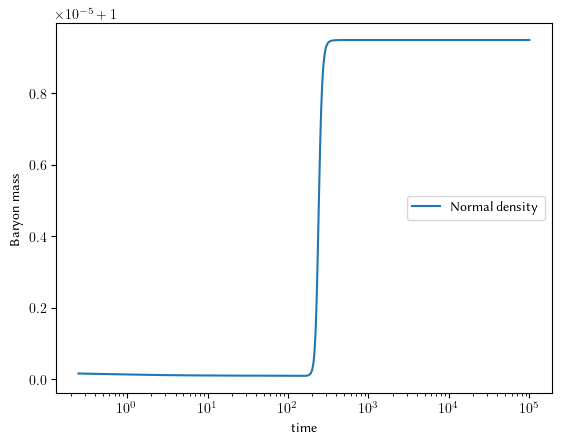

In [50]:
invm=A**2/m_Nucs


def altrho_bY_cgs(y):
    return eta_ini*n_gamma_ini/y[1]**3*gcm3/np.dot(y[n_bparams:6+n_bparams],invm[:6])
    


plt.figure()
plt.plot(soltime/timeunit,np.array([a_cache(soltime[i])**3*rho_bY_cgs(np.array([T_cache(soltime[i]),a_cache(soltime[i])]+list(solY[:,i]))) for i in range(len(soltime))])/np.array([a_cache(soltime[i])**3*altrho_bY_cgs(np.array([T_cache(soltime[i]),a_cache(soltime[i])]+list(solY[:,i]))) for i in range(len(soltime))]),label='Normal density')


plt.xlabel('time')
plt.ylabel('Baryon mass')
#plt.ylim(1e-80,1)
#plt.xlim(0,20)
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='right')
plt.show()


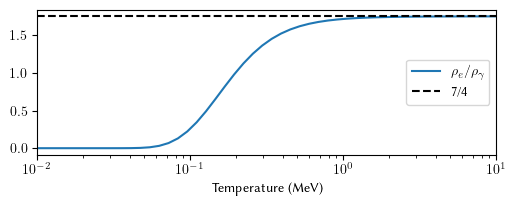

In [51]:
T_test=np.logspace(-2,1)

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

#plt.plot(T_test,[rho_e(T) for T in T_test])
#plt.plot(T_test,[7/4*rho_gamma(T) for T in T_test])
#fig, axes = plt.subplots(1, 1, figsize=(width, height))
fig, axes = plt.subplots(1, 1, figsize=(width, 2))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.075, right=0.975, bottom=0.225, top=0.95)
plt.plot(T_test,np.array([rho_e(T) for T in T_test])/np.array([rho_gamma(T) for T in T_test]),label=r'$\rho_{e}/\rho_{\gamma}$')
#plt.plot(T_cache(soltime),np.array([rho_nu(a_cache(t))/rho_gamma(T_cache(t)) for t in soltime]))
plt.xscale('log')
plt.axhline(7/4,color='k',linestyle='--',label='7/4')
#plt.axhline(n_nu*7/8,color='k',linestyle='--',label='21/8')
plt.xlim(0.01,10)
#plt.axvline(T_ini)
#plt.yscale('log')
#plt.formatter.use_mathtext=True
#plt.ylim(1e-40,1e2)#
plt.xlabel('Temperature (MeV)')
#plt.ylabel(r'$\rho_{e}/\rho_{\gamma}$')
plt.legend(loc='right')

#fig.savefig('TeX/figures/rhoegammaT.pdf')


In [52]:
t_ini/timeunit

0.029531842660077835

In [53]:
rho_e(T_ini)/rho_gamma(T_ini)/7*4

0.999298776895335

In [54]:
def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

In [55]:
#finding rates that contribute to Berylium7 production
all_nuclei = Y_labels[:fnNucs]#["p","n", "h2", "h3", "he3", "he4","Li6","Li7","Be7","Li8"]#,"B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]
bbn_library = reaclibrary.linking_nuclei(all_nuclei)
bbn_network = pyna.networks.PythonNetwork(libraries=bbn_library)

Li7rates = bbn_library.filter(pyna.RateFilter(products=["Li7"], exact=False)).get_rates()
Li7reverserates = bbn_library.filter(pyna.RateFilter(reactants=["Li7"], exact=False)).get_rates()

C12rates= bbn_library.filter(pyna.RateFilter(products=["C12"], exact=False)).get_rates()
C12reverserates= bbn_library.filter(pyna.RateFilter(reactants=["C12"], exact=False)).get_rates()

He4rates= bbn_library.filter(pyna.RateFilter(products=["He4"], exact=False)).get_rates()
He4reverserates= bbn_library.filter(pyna.RateFilter(reactants=["He4"], exact=False)).get_rates()

He3rates= bbn_library.filter(pyna.RateFilter(products=["He3"], exact=False)).get_rates()
He3reverserates= bbn_library.filter(pyna.RateFilter(reactants=["He3"], exact=False)).get_rates()

H3rates= bbn_library.filter(pyna.RateFilter(products=["H3"], exact=False)).get_rates()
H3reverserates= bbn_library.filter(pyna.RateFilter(reactants=["H3"], exact=False)).get_rates()

H2rates= bbn_library.filter(pyna.RateFilter(products=["H2"], exact=False)).get_rates()
H2reverserates= bbn_library.filter(pyna.RateFilter(reactants=["H2"], exact=False)).get_rates()


Li7rates = bbn_library.filter(pyna.RateFilter(products=["Li7"], exact=False)).get_rates()
Li7reverserates = bbn_library.filter(pyna.RateFilter(reactants=["Li7"], exact=False)).get_rates()

filter = pyna.RateFilter(products=["Be7"], exact=False)
Be7rates = bbn_library.filter(filter).get_rates()

reversefilter = pyna.RateFilter(reactants=["Be7"], exact=False)
Be7reverserates = bbn_library.filter(reversefilter).get_rates()
print(Be7rates)
print(Be7reverserates)

[B8 ⟶ p + Be7, C11 ⟶ He4 + Be7, He3 + He4 ⟶ Be7 + 𝛾, Li6 + p ⟶ Be7 + 𝛾, He4 + He4 ⟶ n + Be7, Li6 + H2 ⟶ n + Be7, Li7 + p ⟶ n + Be7, B10 + p ⟶ He4 + Be7, p + He4 + He4 ⟶ H2 + Be7, n + p + He4 + He4 ⟶ H3 + Be7, p + p + He4 + He4 ⟶ He3 + Be7]
[Be7 + e⁻ ⟶ Li7 + 𝜈, Be7 ⟶ p + Li6, Be7 ⟶ He4 + He3, Be7 + p ⟶ B8 + 𝛾, Be7 + He4 ⟶ C11 + 𝛾, Be7 + n ⟶ p + Li7, Be7 + n ⟶ H2 + Li6, Be7 + n ⟶ He4 + He4, Be7 + He4 ⟶ p + B10, Be7 + H2 ⟶ p + He4 + He4, Be7 + H3 ⟶ n + p + He4 + He4, Be7 + He3 ⟶ p + p + He4 + He4]


In [56]:
#Function for evaluating pyna rates at a given point
def ratevalue(rate,i):
    Tpeak=T_cache(soltime[i])*TMeV2T9*1e9
    rho=n_b_ini/a_cache(soltime[i])**3*molcm3
    value=rate.eval(Tpeak)/rho
    #electron capture denpends on electron density approximately equal to baryons
    if rate.__str__()=='Be7 + e⁻ ⟶ Li7 + 𝜈':
        value*=1*rho
    for reactant in rate.reactants:
        index=Y_labels.index(reactant.caps_name)
        value*=solY[index,i]*rho
        

    return  value

(200, 500)

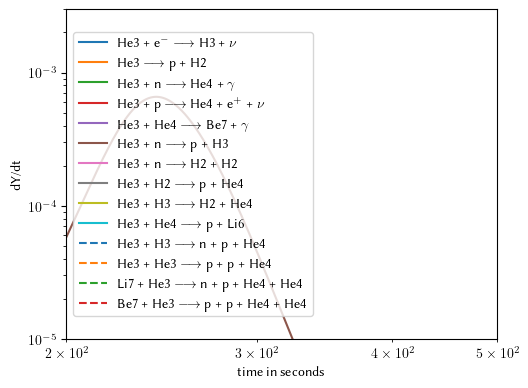

In [135]:
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.13, right=0.975, bottom=0.125, top=0.95)

for ii,rate in enumerate(He3reverserates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))
#plt.plot(soltime/timeunit,[ratevalue(He3reverserates[2],i) for i in range(len(soltime))],line[2],color=colors[2],label=u2latex.unicode_to_latex(He3reverserates[2]))

#plt.plot((fullsolY.t+t_cut)/timeunit,[5100*fullsolY.y[8,i]*fullsolY.y[2,i]*rho_bY_cgs(fullsolY.y[:,i]) for i in range(len(fullsolY.t))],'--k',label='Alter Li6->Li7')

plt.legend(loc='center left')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
plt.yscale('log')
plt.ylim(1e-5,3e-3)
plt.xlim(200,500)
#fig.savefig('TeX/figures/app/He3destruct.pdf')

(200, 500)

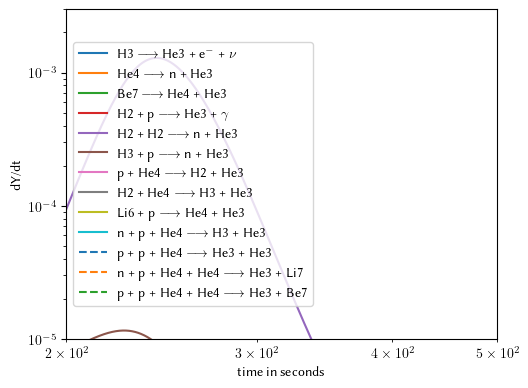

In [130]:
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.13, right=0.975, bottom=0.125, top=0.95)

for ii,rate in enumerate(He3rates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))


plt.legend(loc='center left')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
plt.yscale('log')
plt.ylim(1e-5,3e-3)
plt.xlim(200,500)
#fig.savefig('TeX/figures/app/He3create.pdf')

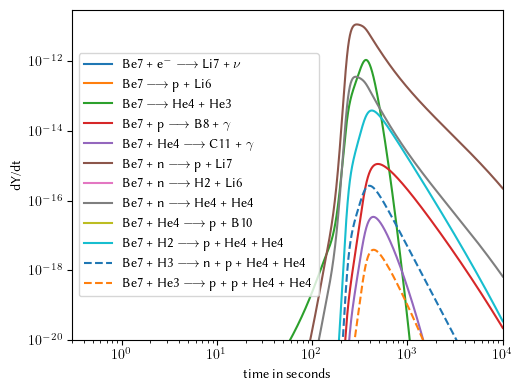

In [85]:
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.13, right=0.975, bottom=0.125, top=0.95)

for ii,rate in enumerate(Be7reverserates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))

#plt.plot((fullsolY.t+t_cut)/timeunit,[5100*fullsolY.y[8,i]*fullsolY.y[2,i]*rho_bY_cgs(fullsolY.y[:,i]) for i in range(len(fullsolY.t))],'--k',label='Alter Li6->Li7')

plt.legend(loc='center left')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
plt.yscale('log')
plt.ylim(1e-20,3e-11)
plt.xlim(0.3,1e4)
#fig.savefig('TeX/figures/app/Be7destruct.pdf')

(200, 500)

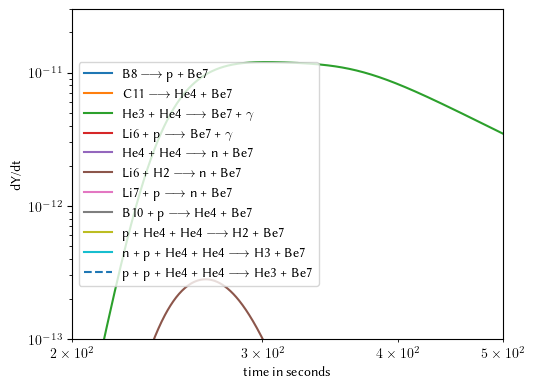

In [129]:
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.13, right=0.975, bottom=0.125, top=0.95)

for ii,rate in enumerate(Be7rates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))


plt.legend(loc='center left')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
plt.yscale('log')
plt.ylim(1e-13,3e-11)#plt.ylim(1e-20,3e-11)
plt.xlim(200,500)
#fig.savefig('TeX/figures/app/Be7create.pdf')

/home/hansbdein/.local/lib/python3.10/site-packages/pynucastro/rates/rate.py:211: RuntimeWarning: overflow encountered in exp
  return lambda tf: np.exp(self.a[0] +


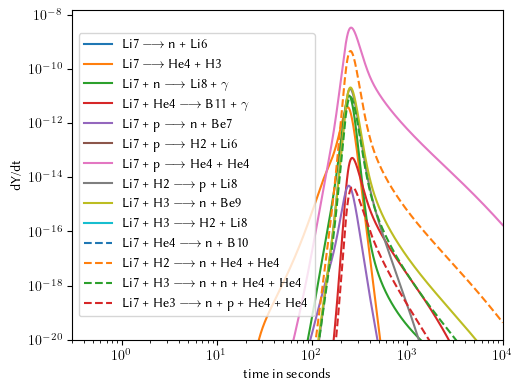

In [87]:
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.13, right=0.975, bottom=0.125, top=0.95)

for ii,rate in enumerate(Li7reverserates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))

#plt.plot((fullsolY.t+t_cut)/timeunit,[5100*fullsolY.y[8,i]*fullsolY.y[2,i]*rho_bY_cgs(fullsolY.y[:,i]) for i in range(len(fullsolY.t))],'--k',label='Alter Li6->Li7')

plt.legend(loc='center left')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
plt.yscale('log')
plt.ylim(1e-20,1.5e-8)
plt.xlim(0.3,1e4)
#fig.savefig('TeX/figures/app/Li7destruct.pdf')

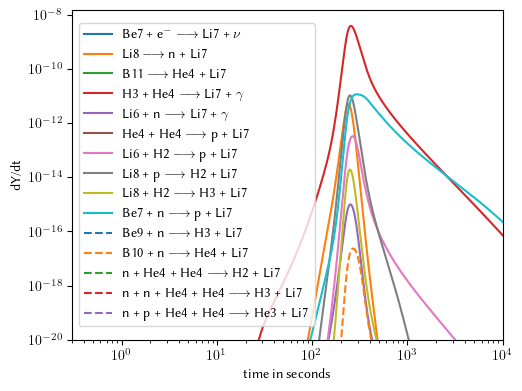

In [88]:
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.13, right=0.975, bottom=0.125, top=0.95)

for ii,rate in enumerate(Li7rates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))

#plt.plot((fullsolY.t+t_cut)/timeunit,[5100*fullsolY.y[8,i]*fullsolY.y[2,i]*rho_bY_cgs(fullsolY.y[:,i]) for i in range(len(fullsolY.t))],'--k',label='Alter Li6->Li7')

plt.legend(loc='center left')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
plt.yscale('log')
plt.ylim(1e-20,1.5e-8)
plt.xlim(0.3,1e4)
#fig.savefig('TeX/figures/app/Li7create.pdf')

(200, 300)

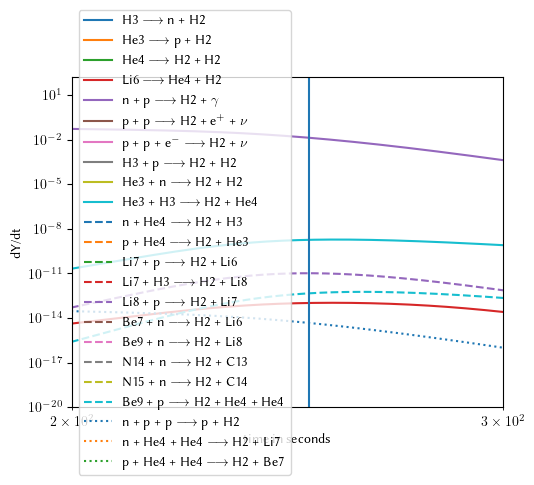

In [105]:
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.13, right=0.975, bottom=0.125, top=0.95)

for ii,rate in enumerate(H2rates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))

#plt.plot((fullsolY.t+t_cut)/timeunit,[5100*fullsolY.y[8,i]*fullsolY.y[2,i]*rho_bY_cgs(fullsolY.y[:,i]) for i in range(len(fullsolY.t))],'--k',label='Alter Li6->Li7')
plt.axvline(250)
plt.legend(loc='center left')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
plt.yscale('log')
plt.ylim(1e-20,1.5e2)
plt.xlim(200,300)
#fig.savefig('TeX/figures/app/Dcreate.pdf')

In [115]:
Yla[2]

'H2'

/home/hansbdein/.local/lib/python3.10/site-packages/pynucastro/rates/rate.py:211: RuntimeWarning: overflow encountered in exp
  return lambda tf: np.exp(self.a[0] +


(0.3, 10000.0)

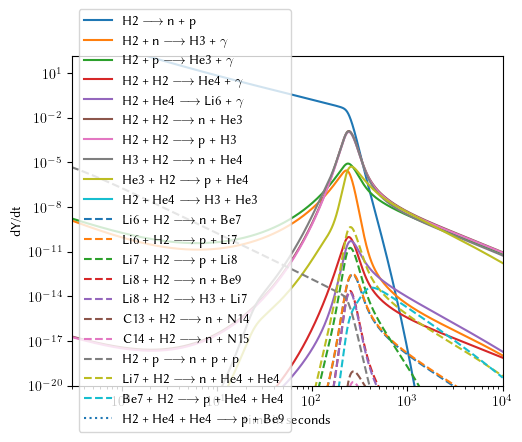

In [117]:
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.13, right=0.975, bottom=0.125, top=0.95)

for ii,rate in enumerate(H2reverserates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))

#plt.plot((fullsolY.t+t_cut)/timeunit,[5100*fullsolY.y[8,i]*fullsolY.y[2,i]*rho_bY_cgs(fullsolY.y[:,i]) for i in range(len(fullsolY.t))],'--k',label='Alter Li6->Li7')

plt.legend(loc='center left')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
plt.yscale('log')
plt.ylim(1e-20,1.5e2)
plt.xlim(0.3,1e4)
#fig.savefig('TeX/figures/app/Dcreate.pdf')

In [ ]:

fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.075, right=0.975, bottom=0.225, top=0.95)

for ii,rate in enumerate(He4rates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))

plt.legend(loc='center right')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
#plt.yscale('log')
plt.xlim(200,300)
plt.ylim(1e-40,0.002)

(1e-40, 1)

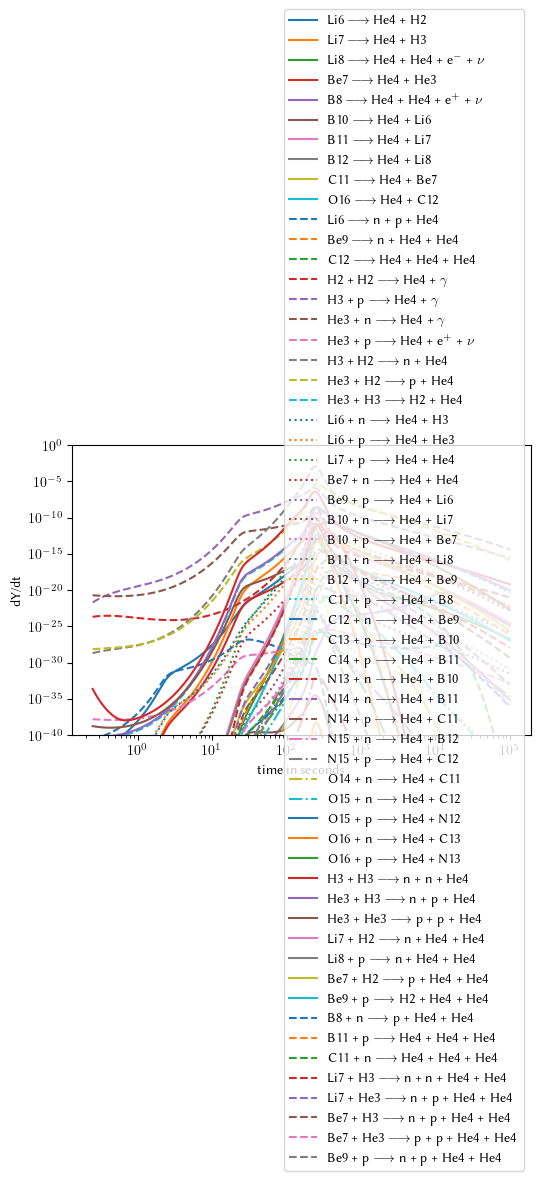

In [136]:

fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.075, right=0.975, bottom=0.225, top=0.95)

for ii,rate in enumerate(He4rates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))

plt.legend(loc='center right')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
plt.yscale('log')
plt.ylim(1e-40,1)

In [62]:
def ratevalue10(rate,i):
    Tpeak=T_cache(soltime[i])*TMeV2T9*1e9
    rho=n_b_ini/a_cache(soltime[i])**3*molcm3*1e7
    value=rate.eval(Tpeak)/rho
    #electron capture denpends on electron density approximately equal to baryons
    if rate.__str__()=='Be7 + e⁻ ⟶ Li7 + 𝜈':
        value*=1*rho
    for reactant in rate.reactants:
        index=Y_labels.index(reactant.caps_name)
        value*=solY[index,i]*rho
        

    return  value

Text(0, 0.5, 'dY/dt')

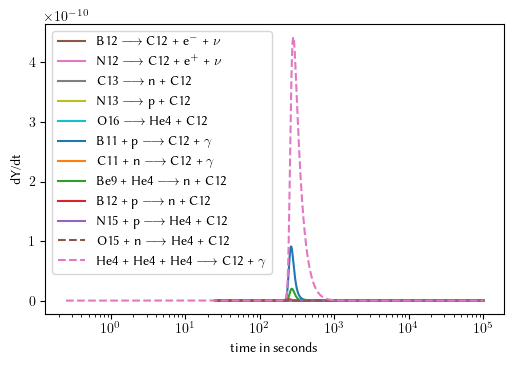

In [63]:
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.075, right=0.975, bottom=0.225, top=0.95)

for ii,rate in enumerate(C12rates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue10(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii+5],label=u2latex.unicode_to_latex(rate))

#plt.plot((fullsolY.t+t_cut)/timeunit,[5100*fullsolY.y[8,i]*fullsolY.y[2,i]*rho_bY_cgs(fullsolY.y[:,i]) for i in range(len(fullsolY.t))],'--k',label='Alter Li6->Li7')

plt.legend()
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
#plt.yscale('log')
#plt.ylim(1e-70,1.5e-11)
#plt.yscale('log')
#plt.ylim(1e-20,1e-17)

In [64]:

lightrates=reaclibrary.linking_nuclei(["p","n", "h2", "h3", "he3", "he4"]).get_rates()
#Li7rates = bbn_library.filter(pyna.RateFilter(products=["Li7"], exact=False)).get_rates()
#Li7reverserates = bbn_library.filter(pyna.RateFilter(reactants=["Li7"], exact=False)).get_rates()


In [65]:
lightrates

[n ⟶ p + e⁻ + 𝜈,
 H3 ⟶ He3 + e⁻ + 𝜈,
 He3 + e⁻ ⟶ H3 + 𝜈,
 H2 ⟶ n + p,
 H3 ⟶ n + H2,
 He3 ⟶ p + H2,
 He4 ⟶ n + He3,
 He4 ⟶ p + H3,
 He4 ⟶ H2 + H2,
 n + p ⟶ H2 + 𝛾,
 p + p ⟶ H2 + e⁺ + 𝜈,
 p + p + e⁻ ⟶ H2 + 𝜈,
 H2 + n ⟶ H3 + 𝛾,
 H2 + p ⟶ He3 + 𝛾,
 H2 + H2 ⟶ He4 + 𝛾,
 H3 + p ⟶ He4 + 𝛾,
 He3 + n ⟶ He4 + 𝛾,
 He3 + p ⟶ He4 + e⁺ + 𝜈,
 H2 + H2 ⟶ n + He3,
 H2 + H2 ⟶ p + H3,
 H3 + p ⟶ n + He3,
 H3 + p ⟶ H2 + H2,
 H3 + H2 ⟶ n + He4,
 He3 + n ⟶ p + H3,
 He3 + n ⟶ H2 + H2,
 He3 + H2 ⟶ p + He4,
 He3 + H3 ⟶ H2 + He4,
 n + He4 ⟶ H2 + H3,
 p + He4 ⟶ H2 + He3,
 H2 + He4 ⟶ H3 + He3,
 H2 + p ⟶ n + p + p,
 H3 + H3 ⟶ n + n + He4,
 He3 + H3 ⟶ n + p + He4,
 He3 + He3 ⟶ p + p + He4,
 n + p + p ⟶ p + H2,
 n + n + He4 ⟶ H3 + H3,
 n + p + He4 ⟶ H3 + He3,
 p + p + He4 ⟶ He3 + He3]

(1e-20, 1)

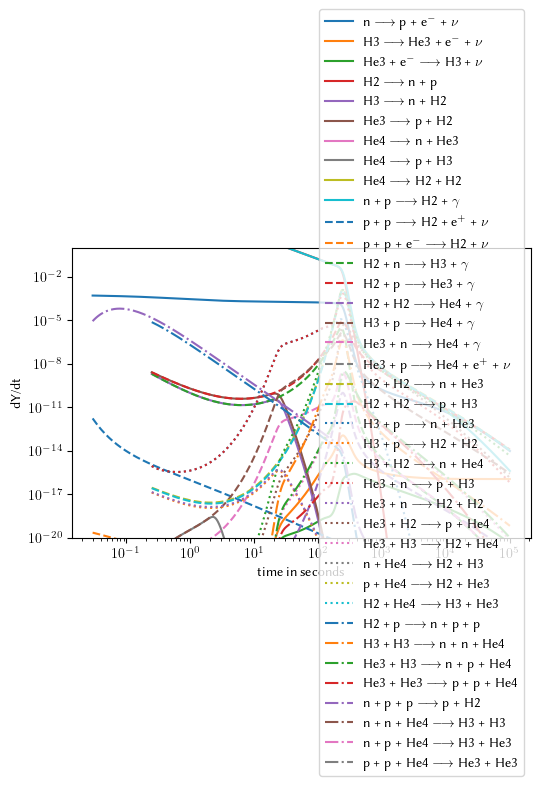

In [66]:

fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.075, right=0.975, bottom=0.225, top=0.95)

for ii,rate in enumerate(lightrates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))

plt.legend(loc='center right')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
plt.yscale('log')
plt.ylim(1e-20,1)

(1e-20, 0.0021)

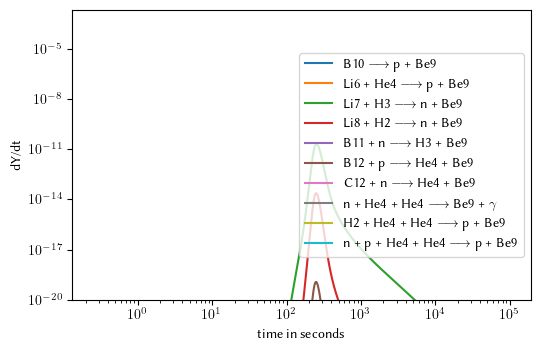

In [67]:
Be9rates = bbn_library.filter(pyna.RateFilter(products=["Be9"], exact=False)).get_rates()


fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.075, right=0.975, bottom=0.225, top=0.95)

for ii,rate in enumerate(Be9rates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))

#plt.plot((fullsolY.t+t_cut)/timeunit,[5100*fullsolY.y[8,i]*fullsolY.y[2,i]*rho_bY_cgs(fullsolY.y[:,i]) for i in range(len(fullsolY.t))],'--k',label='Alter Li6->Li7')

plt.legend(loc='center right')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
#plt.yscale('log')
#plt.ylim(1e-70,1.5e-11)
plt.yscale('log')
plt.ylim(1e-20,0.0021)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


(1e-18, 2e-13)

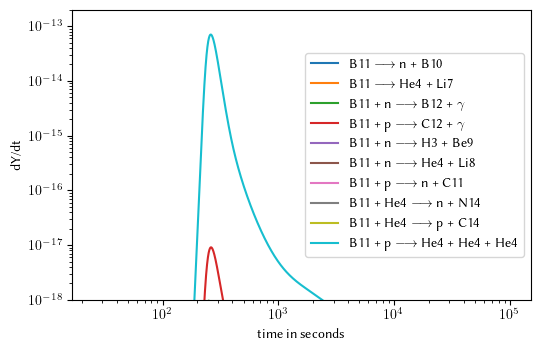

In [68]:
B11reverserates = bbn_library.filter(pyna.RateFilter(reactants=["B11"], exact=False)).get_rates()

fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.075, right=0.975, bottom=0.225, top=0.95)

for ii,rate in enumerate(B11reverserates):
    print(ratevalue(rate,1210))
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii],color=colors[ii],label=u2latex.unicode_to_latex(rate))

#plt.plot((fullsolY.t+t_cut)/timeunit,[5100*fullsolY.y[8,i]*fullsolY.y[2,i]*rho_bY_cgs(fullsolY.y[:,i]) for i in range(len(fullsolY.t))],'--k',label='Alter Li6->Li7')

plt.legend(loc='center right')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
#plt.yscale('log')
#plt.ylim(1e-70,1.5e-11)
plt.yscale('log')
plt.ylim(1e-18,2e-13)

(1e-30, 1.5e-11)

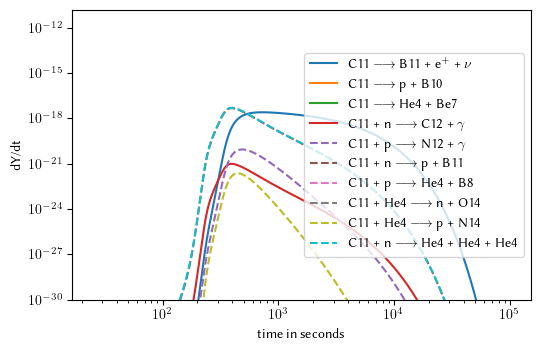

In [69]:
C11reverserates = bbn_library.filter(pyna.RateFilter(reactants=["C11"], exact=False)).get_rates()

fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.075, right=0.975, bottom=0.225, top=0.95)

for ii,rate in enumerate(C11reverserates):
    #print(rate)
    plt.plot(soltime/timeunit,[ratevalue(rate,i) for i in range(len(soltime))],line[ii+6],color=colors[ii],label=u2latex.unicode_to_latex(rate))

#plt.plot((fullsolY.t+t_cut)/timeunit,[5100*fullsolY.y[8,i]*fullsolY.y[2,i]*rho_bY_cgs(fullsolY.y[:,i]) for i in range(len(fullsolY.t))],'--k',label='Alter Li6->Li7')

plt.legend(loc='center right')
plt.xscale('log')
plt.xlabel('time in seconds')
plt.ylabel('dY/dt')
plt.yscale('log')
plt.ylim(1e-30,1.5e-11)
#plt.yscale('log')
#plt.ylim(1e-20,0.0021)